# Movie Reviews Classification
  * Positive
  * Neutral
  * Negative

# Prepare data

## Load data from drive

In [ ]:
from google.colab import drive
drive.mount("/content/MyDrive")

Mounted at /content/MyDrive


In [ ]:
%cp '/content/MyDrive/MyDrive/Colab Notebooks/Data Processing/data/data_shuffled.pkl' '/content'

In [ ]:
import pandas as pd
pd.set_option('max_colwidth', 200)

data = pd.read_pickle('/content/data_shuffled.pkl')
data

,Review,Rate,Label
0,ok maybe loosely based true loose ever actually actor series come across complete idiot fighting charge bumbling ever turn doesnt really sound interestingeven im take partially true would watch su...,1,negative
1,know slog along promising big reveal never deliver well go cant sleep,1,negative
2,binged first three episode honestly cant wait next week instalment great lot interesting twist finger crossed high standard maintained right episode impressive faralyla browne magnificent job play...,9,positive
3,inspection drama starring jeremy pope elli french young gay black man join marine escape abusive mother find place worldthis powerful emotional experience pope give incredible performance elli str...,8,positive
4,saw back sundance festivalthe neighbor john levi witness supernatural event los angeles apartment building realize documenting paranormal could inject fame fortune wasted life everdeeper darker ra...,7,positive
...,...,...,...
73982,love director last shin godzilla focus bureaucratic struggle well visually astonishing creature messing around actual city tokyo authenticity quite new contributes multlayered attractiveness lates...,3,negative
73983,first miniseries amazing start finish cast great matthew goode really steal robert evans god im surprised golden globe never considered nomination rare miniseries come along take back history see ...,10,positive
73984,recorded hoped see scenery glacier national park presented obvious right away wasnt glacier national park thought must canadian glacier national park much farther north along tch nope either turn ...,5,neutral
73985,saw sneak preview today wife im veteran player dm shes never played laughed whole thing riveted action sequence indicating excellent intro world dd inexperienced enchanted got right iconic monster...,9,positive


In [ ]:
reviews = list(data['Review'])
labels = list(data['Label'])

## Label encoding

In [ ]:
classes = ['positive', 'neutral', 'negative']
label_mapping = {label: idx for idx, label in enumerate(classes)}

labels = [label_mapping[label] for label in labels]

## Train/Test split

In [ ]:
import numpy as np
from sklearn.model_selection import train_test_split

# Chia dữ liệu thành tập huấn luyện và tập kiểm tra
X_train, X_test, y_train, y_test = train_test_split(reviews, labels, test_size=0.2, stratify=labels, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, stratify=y_train, random_state=42)

print(len(X_train))
print(len(X_val))
print(len(X_test))

47351
11838
14798


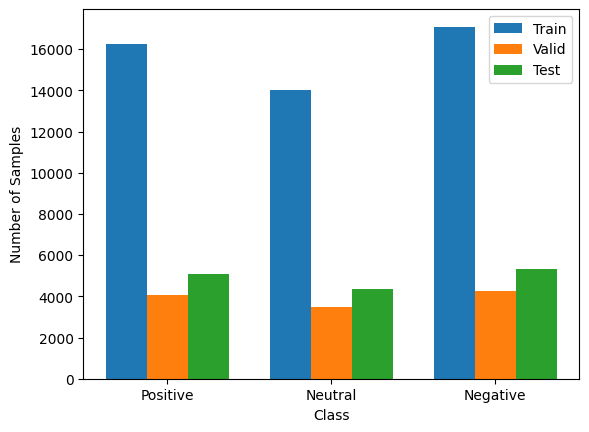

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

train_counts = pd.Series(y_train).value_counts().sort_index(ascending=True)
valid_counts = pd.Series(y_val).value_counts().sort_index(ascending=True)
test_counts = pd.Series(y_test).value_counts().sort_index(ascending=True)

train_samples = [train_counts[0], train_counts[1], train_counts[2]]  # Số mẫu của từng class trong tập train
valid_samples = [valid_counts[0], valid_counts[1], valid_counts[2]]  # Số mẫu của từng class trong tập valid
test_samples = [test_counts[0], test_counts[1], test_counts[2]]      # Số mẫu của từng clas trong tập test

# Số lượng class
num_classes = len(train_samples)

# Tạo các index cho các class
class_indices = np.arange(num_classes)

# Độ rộng của cột
bar_width = 0.25

# Vẽ biểu đồ
class_names = ['Positive', 'Neutral', 'Negative']
plt.bar(class_indices, train_samples, width=bar_width, label='Train')
plt.bar(class_indices + bar_width, valid_samples, width=bar_width, label='Valid')
plt.bar(class_indices + 2 * bar_width, test_samples, width=bar_width, label='Test')
plt.xlabel('Class')
plt.ylabel('Number of Samples')
plt.xticks(class_indices + bar_width, class_names)
plt.legend()
plt.show()

## Doc2Vec

In [ ]:
from gensim.models.doc2vec import Doc2Vec, TaggedDocument

# preproces the documents, and create TaggedDocuments
tagged_data = [TaggedDocument(words=doc.split(' '), tags=[str(i)]) for i, doc in enumerate(X_train)]

In [ ]:
#doc2vec parameters
vector_size = 300 # word vector size
window_size = 15 # context window size
min_count = 1 # minimum frequency threshold for word types
train_epoch = 100
dm = 0 #0 = dbow; 1 = dmpv

In [ ]:
model = Doc2Vec(vector_size=vector_size, window=window_size, min_count=min_count, dm=dm, dbow_words=1, epochs=train_epoch)

model.build_vocab(tagged_data)
model.train(tagged_data,
            total_examples=model.corpus_count,
            epochs=model.epochs)

In [ ]:
model.save('/content/MyDrive/MyDrive/Colab Notebooks/Data Processing/model/dbow.h5')

In [ ]:
from gensim.models.doc2vec import Doc2Vec

# load Doc2Vec model
d2v = Doc2Vec.load('/content/MyDrive/MyDrive/Colab Notebooks/Fake news detection/model/dbow.h5')

# get the document vectors
X_train = np.array([d2v.infer_vector(doc.split(' ')) for doc in X_train])
X_val = np.array([d2v.infer_vector(doc.split(' ')) for doc in X_val])
X_test = np.array([d2v.infer_vector(doc.split(' ')) for doc in X_test])

In [ ]:
# one-hot encoding
num_classes = len(np.unique(y_train))
y_train = np.eye(num_classes)[y_train]
y_val = np.eye(num_classes)[y_val]
y_test = np.eye(num_classes)[y_test]

# Modeling

In [ ]:
import itertools
import matplotlib.pyplot as plt

def plot_confusion_matrix(cm, class_names):
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title("Confusion matrix")
    plt.colorbar()
    tick_marks = np.arange(len(class_names))
    plt.xticks(tick_marks, class_names, rotation=45)
    plt.yticks(tick_marks, class_names)

    # Compute the labels from the normalized confusion matrix.
    labels = np.around(cm.astype('float') / cm.sum(axis=1)[:, np.newaxis], decimals=2)

    # Use white text if squares are dark; otherwise black.
    threshold = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        color = "white" if cm[i, j] > threshold else "black"
        plt.text(j, i, labels[i, j], horizontalalignment="center", color=color)

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

## Naive Bayes

**Hyperparameter tuning with GridSearchCV**

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.naive_bayes import MultinomialNB

param_grid = {'alpha': [0.1, 0.3, 0.5, 0.7, 0.9]}
model = MultinomialNB()
grid_search = GridSearchCV(model, param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_val, y_val)

GridSearchCV(cv=5, estimator=MultinomialNB(),
             param_grid={'alpha': [0.5, 1.0, 1.5, 2.0, 2.5, 3.0]},
             scoring='accuracy')

In [ ]:
print("Best Parameters: ", grid_search.best_params_)
print("Best Score: ", grid_search.best_score_)

Best Parameters:  {'alpha': 0.3}
Best Score:  0.7023165080252454


In [ ]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report

# Train a Naive Bayes classifier
nb_classifier = MultinomialNB(alpha=0.3)
nb_classifier.fit(X_train, y_train)

MultinomialNB(alpha=0.3)

In [ ]:
# Predict on the train set
y_pred = nb_classifier.predict(X_train)

# Evaluate the classifier
print(classification_report(y_train, y_pred))

              precision    recall  f1-score   support

           0       0.92      0.89      0.91     13400
           1       0.81      0.83      0.82     13994
           2       0.86      0.86      0.86     12998

    accuracy                           0.86     40392
   macro avg       0.86      0.86      0.86     40392
weighted avg       0.86      0.86      0.86     40392


In [ ]:
# Predict on the test set
y_pred = nb_classifier.predict(X_test)

# Evaluate the classifier
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.86      0.88      0.87     13400
           1       0.74      0.84      0.79     13994
           2       0.78      0.87      0.82     12998

    accuracy                           0.82     40392
   macro avg       0.79      0.86      0.82     40392
weighted avg       0.79      0.86      0.82     40392


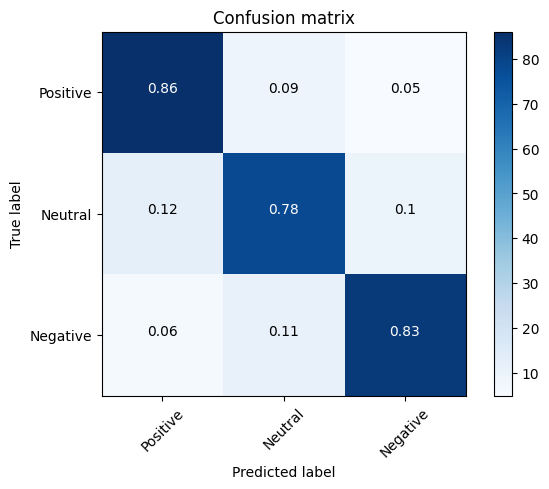

In [ ]:
from sklearn.metrics import confusion_matrix

y_pred = model.predict(X_test)
y_pred = np.argmax(y_pred, axis=1)
cm = confusion_matrix(np.argmax(y_test, axis=1), y_pred)

classes = ['Positive', 'Neutral', 'Negative']
plot_confusion_matrix(cm, classes)

## BiLSTM

### Create and train model

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Bidirectional, Dropout
from tensorflow.keras import regularizers

model = Sequential(name='Bidirectional_LSTM')
model.add(Bidirectional(LSTM(100), input_shape=(1, 300)))
model.add(Dropout(0.3))
model.add(Dense(100, activation='relu', kernel_regularizer=regularizers.l2()))
model.add(Dropout(0.3))
model.add(Dense(3, activation='softmax'))
model.summary()

Model: "Bidirectional_LSTM"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional_3 (Bidirecti  (None, 200)               320800    
 onal)                                                           
                                                                 
 dropout_6 (Dropout)         (None, 200)               0         
                                                                 
 dense_6 (Dense)             (None, 100)               20100     
                                                                 
 dropout_7 (Dropout)         (None, 100)               0         
                                                                 
 dense_7 (Dense)             (None, 3)                 303       
                                                                 
Total params: 341203 (1.30 MB)
Trainable params: 341203 (1.30 MB)
Non-trainable params: 0 (0.00 Byte)
____________

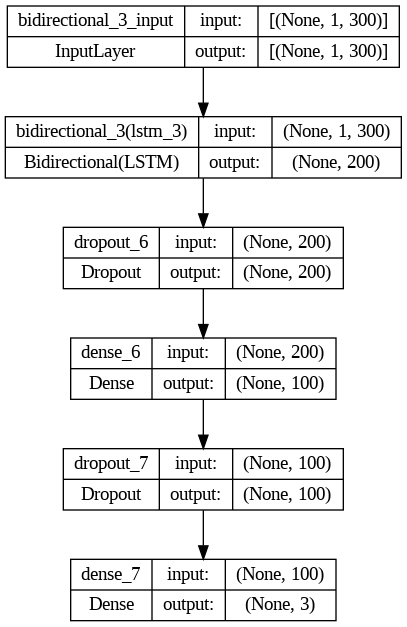

In [ ]:
from keras.utils import plot_model

plot_model(model, show_shapes=True)

In [82]:
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
history = model.fit(X_train, y_train, epochs=20, validation_data=(X_val, y_val))

Epoch 1/20
1196/1196 [==============================] - 40s 24ms/step - loss: 0.7885 - accuracy: 0.6672 - val_loss: 0.6877 - val_accuracy: 0.7049
Epoch 2/20
1196/1196 [==============================] - 28s 23ms/step - loss: 0.5941 - accuracy: 0.7672 - val_loss: 0.5841 - val_accuracy: 0.7536
Epoch 3/20
1196/1196 [==============================] - 27s 22ms/step - loss: 0.5142 - accuracy: 0.7995 - val_loss: 0.4951 - val_accuracy: 0.7684
Epoch 4/20
1196/1196 [==============================] - 27s 23ms/step - loss: 0.4054 - accuracy: 0.8241 - val_loss: 0.4312 - val_accuracy: 0.7865
Epoch 5/20
1196/1196 [==============================] - 27s 23ms/step - loss: 0.3004 - accuracy: 0.8461 - val_loss: 0.3874 - val_accuracy: 0.8032
Epoch 6/20
1196/1196 [==============================] - 34s 29ms/step - loss: 0.2087 - accuracy: 0.8661 - val_loss: 0.3494 - val_accuracy: 0.8215
Epoch 7/20
1196/1196 [==============================] - 30s 25ms/step - loss: 0.1753 - accuracy: 0.8831 - val_loss: 0.3235 -

(0.0, 0.8223699999999999)

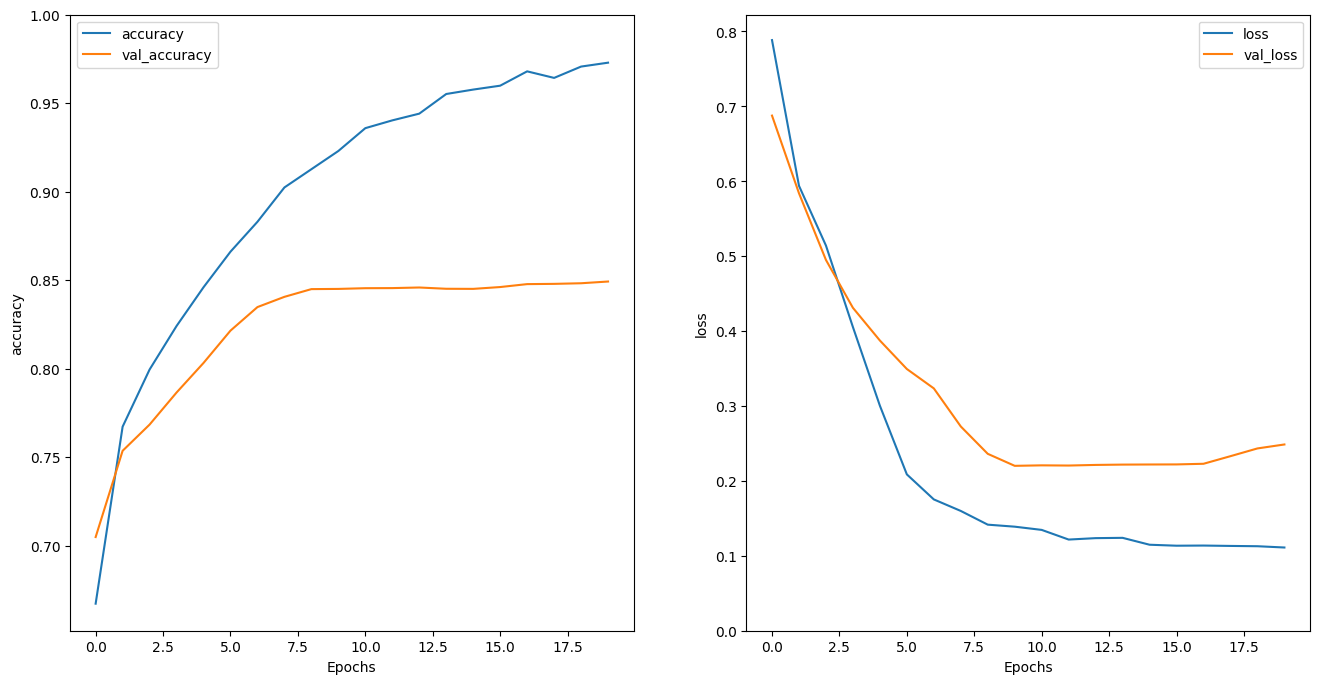

In [ ]:
import matplotlib.pyplot as plt

def plot_graphs(history, metric):
    plt.plot(history[metric])
    plt.plot(history['val_'+metric], '')
    plt.xlabel("Epochs")
    plt.ylabel(metric)
    plt.legend([metric, 'val_'+metric])

plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plot_graphs(history.history, 'accuracy')
plt.ylim(None, 1)
plt.subplot(1, 2, 2)
plot_graphs(history.history, 'loss')
plt.ylim(0, None)

### Result

In [ ]:
test_loss, test_acc = model.evaluate(X_test, y_test)

print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)

395/395 [==============================] - 7s 16ms/step - loss: 0.1872 - accuracy: 0.8648
Test Loss: 0.187232255935669
Test Accuracy: 0.8648380697250366


In [ ]:
from sklearn.metrics import classification_report

# Predict on the test set
y_pred = model.predict(X_test)
y_pred = np.argmax(y_pred, axis=1)

# Evaluate the classifier
print(classification_report(np.argmax(y_test, axis=1), y_pred))

              precision    recall  f1-score   support

           0       0.87      0.92      0.89     13400
           1       0.81      0.85      0.83     13994
           2       0.85      0.89      0.87     12998

    accuracy                           0.86     40392
   macro avg       0.84      0.89      0.86     40392
weighted avg       0.84      0.89      0.86     40392


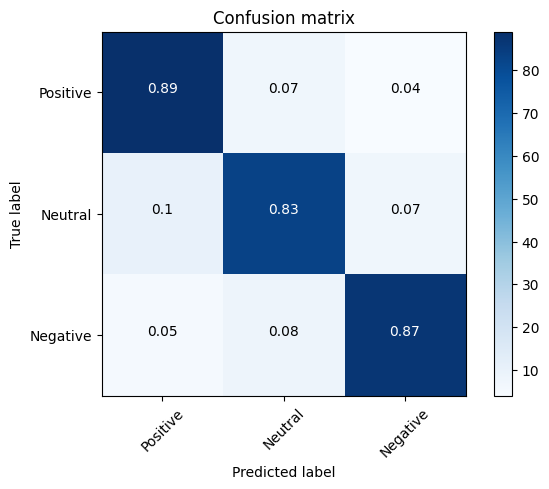

In [ ]:
from sklearn.metrics import confusion_matrix

y_pred = model.predict(X_test)
y_pred = np.argmax(y_pred, axis=1)
cm = confusion_matrix(np.argmax(y_test, axis=1), y_pred)

classes = ['Positive', 'Neutral', 'Negative']
plot_confusion_matrix(cm, classes)